 * Reference:
https://www.youtube.com/watch?v=Y_hzMnRXjhI&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=3
 * ChatGPT: TensorFlow Multiclass Loss Functions

In [1]:
#Importing required packages.

import warnings

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pathlib

import requests
import json
import time
import csv
from urllib import parse

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline


from experiment.api import mlflow as mlflow_api


In [2]:
#Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading dataset
df = pd.read_csv(pathlib.Path("../data") / "output.csv")


In [4]:
#Standard random state for all operations
RANDOM_STATE = 42

In [5]:
mlflow = mlflow_api.MLFlow(local_storage=True)
mlflow.clean()

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


# 1. Exploratory Data Analysis

In [6]:
#Let's check how the data is distributed
df.head()

,Unnamed: 0,patient_no,protocol_no,text,report_date,study_no,report_count
0,5420,2005183286,22741231,Kafa tabanı ve verteks arasından elde olunan k...,2022-06-20,NaN,27
1,6122,2006000036,22219950,BEYİN BT Hastanın filmi 09/01/2022 tarihli ...,2022-02-01,12471911.0,26
2,16908,2008509284,22344550,Kontrastsız beyin BT tetkiki İnfratentoria...,2022-02-08,12506525.0,20
3,25,2004004697,22023602,Kontrastsız beyin BT tetkiki İnfratentor...,2021-12-27,NaN,19
4,16219,2008451292,22591624,Beyin BT tetkiki 28/04/2022 Hastanın filmi b...,2022-05-24,12612882.0,18


In [7]:
#Information about the data columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    24354 non-null  int64  
 1   patient_no    24354 non-null  int64  
 2   protocol_no   24354 non-null  int64  
 3   text          24354 non-null  object 
 4   report_date   18688 non-null  object 
 5   study_no      10996 non-null  float64
 6   report_count  24354 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.3+ MB


In [8]:
df.columns

Index(['Unnamed: 0', 'patient_no', 'protocol_no', 'text', 'report_date',
       'study_no', 'report_count'],
      dtype='object')

In [9]:
df.shape

(1599, 12)

<Axes: ylabel='count'>

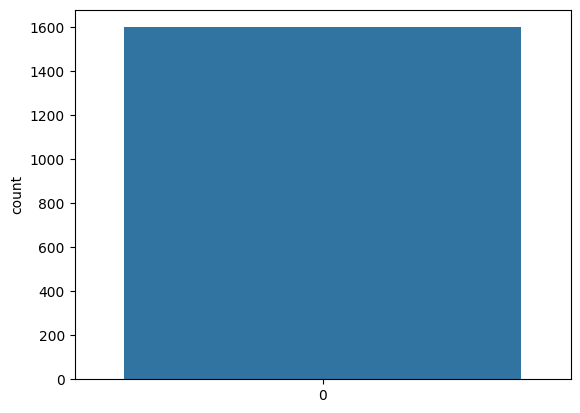

In [11]:
sns.countplot(df['quality'])

# 2. Data Preprocessing

In [12]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate z-scores of `df`
    z_scores = stats.zscore(df)

    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    df = df[filtered_entries]
    return df


# Create a reproducible function for the input data
def apply_feature_engineering_preprocessing(df: pd.DataFrame) -> pd.DataFrame:

    # Making binary classificaion for the response variable.
    # Dividing wine as good and bad by giving the limit for the quality
    bins = (2, 6.5, 8)
    group_names = ["bad", "good"]
    df["quality"] = pd.cut(df["quality"], bins=bins, labels=group_names)

    # Now lets assign a labels to our quality variable
    label_quality = LabelEncoder()

    # Bad becomes 0 and good becomes 1
    df["quality"] = label_quality.fit_transform(df["quality"])

    df = remove_outliers(df)
    return df


In [13]:
#Apply feature engineering
df = apply_feature_engineering_preprocessing(df)

df.head(20)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0
6,7.9,0.600,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,0
7,7.3,0.650,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,1
8,7.8,0.580,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,1
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,0


In [14]:
df['quality'].value_counts()

quality
0    1257
1     201
Name: count, dtype: int64

<Axes: ylabel='count'>

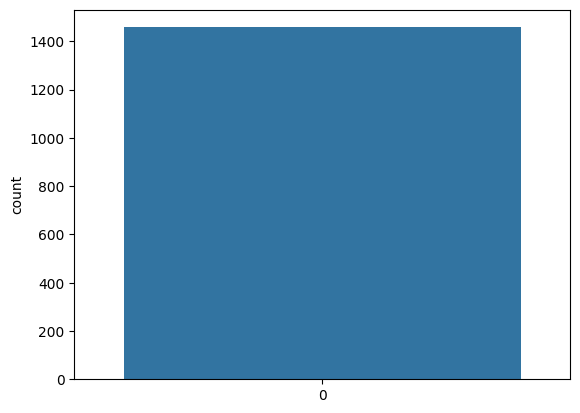

In [15]:
sns.countplot(df['quality'])

We have an unbalanced data set.

In [16]:
# Now seperate the dataset to feature and target variables
X = df.drop("quality", axis=1)
y = df["quality"]


In [17]:
# Train and test splitting of data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


# 3. Model Creation

In [18]:
# Apply preprocessing
preprocessing = ColumnTransformer(
    [
        # Column dropper
        ("column_dropper", "drop", ["residual sugar"]),
    ],
    remainder="passthrough",
)


In [19]:
# Creating the pipeline
clf = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("scaler", StandardScaler()),  # scale values before PCA
        ("pca", PCA()),
        ("classification", KNeighborsClassifier()),
    ]
)


In [20]:
# Try different hyperparamaters
param_grid = [
    {
        "pca__n_components": list(range(3, 10)),
        "classification__n_neighbors": [3, 4, 5, 6, 7, 8],
        "classification__leaf_size": [10, 20, 30, 40, 50],
    }
]


In [21]:
clf = GridSearchCV(
    clf,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring="accuracy",
    return_train_score=True,
    verbose=1,
)


### 3.1 Without mlflow

In [22]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('column_dropper',
                                                                         'drop',
                                                                         ['residual '
                                                                          'sugar'])])),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('classification',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'classification__leaf_size': [10, 20, 30, 40, 50],
                          'classification__n_neighbors': [3, 4, 5, 6, 7, 8],
                          'pca__n_components': [3, 4, 5, 6, 7, 8, 9]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [23]:
#Listing the best parameters for the param_grid:
clf.best_params_

{'classification__leaf_size': 10,
 'classification__n_neighbors': 4,
 'pca__n_components': 6}

In [24]:
#Get the best score
clf.best_score_

0.8842265507501559

In [25]:
#Store the best model in a variable
best_model = clf.best_estimator_
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('column_dropper', 'drop',
                                                  ['residual sugar'])])),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=6)),
                ('classification',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=4))])

### Try on unseen data

In [26]:
#Let's use the test set to create predictions
predictions = best_model.predict(X_test)

In [27]:
#Calculating the accuracy score manually
score = accuracy_score(y_test, predictions)
score

0.8904109589041096

Since the target column is unbalanced, we should check f1 score, too.

In [28]:
score = f1_score(y_test, predictions)
score

0.3846153846153846

As expected, f1 score is much lower because our dataset is unbalanced.

In [29]:
#Creating the confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[250   8]
 [ 24  10]]


Text(0.5, 1.0, 'Accuracy Score: 0.3846153846153846')

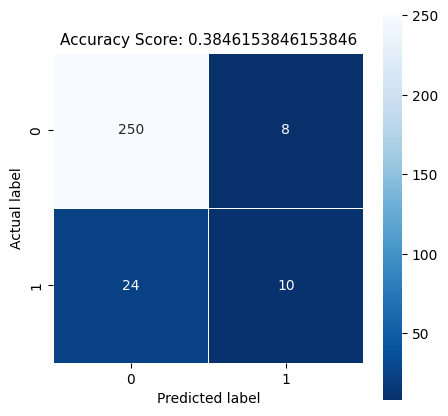

In [30]:
#Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 11)

### 3.2 With mlflow

#### 3.2.1 Train and log models using mlflow

In [31]:
def try_different_neighbors(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    mlflow: mlflow_api.MLFlow,
    leaf_size: int,
    n_jobs: int,
    neighbor_array: list[int],
) -> str:
    """
    This function tries different neighbors on the model
    """

    max_f1 = 0

    for n_neighbors in neighbor_array:
        knn = KNeighborsClassifier(
            leaf_size=leaf_size, n_neighbors=n_neighbors, n_jobs=n_jobs
        )
        knn.fit(X_train, y_train)

        # let's use the test set to create predictions
        predictions = knn.predict(X_test)

        # calculating the accuracy score manually
        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)

        log_dict = {
            "params": {"n_neighbors": n_neighbors},
            "metrics": {"accuracy": accuracy, "f1": f1},
        }

        temp_run_id = mlflow.log_experiment_run(
            model=knn,
            experiment_name="KNN Experiments",
            run_name=f"KNN: {n_neighbors}",
            log_dict=log_dict,
            registered_model_name="knn_n_neighbours",
            tags={
                "model": "knn"
            }
        )

        if f1 > max_f1:
            run_id = temp_run_id

    return run_id


In [32]:
# run the tracking server in background
mlflow.run_server()

In [33]:
# Start logging with mlflow
neighbors = list(range(3, 6))

run_id = try_different_neighbors(
    X_train,
    X_test,
    y_train,
    y_test,
    mlflow=mlflow,
    leaf_size=10,
    n_jobs=-1,
    neighbor_array=neighbors,
)


2023/07/23 23:19:22 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/07/23 23:19:22 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

* n_neighbors = 5 is the best performing model:

#### 3.1.2 Get predictions directly from an API endpoint

First, you should run this command to start the server:

In [34]:
# serve a model with the best f1 score
mlflow.serve_model(run_id)

In [35]:
def get_prediction_from_server(row, mlflow: mlflow_api.MLFlow):
    """
    This functions receives response from the machine learning server
    """

    row = row[:-1]
    data = {"dataframe_split": {"columns": list(X_train.columns), "data": [row]}}
    response = mlflow.get_predictions(data)

    return response.json()


In [36]:
# wait for 5 seconds before the model server starts
time.sleep(5)

2023/07/23 23:19:33 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2023/07/23 23:19:33 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 127.0.0.1:1234 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2023-07-23 23:19:33 +0200] [13926] [INFO] Starting gunicorn 20.1.0
[2023-07-23 23:19:33 +0200] [13926] [INFO] Listening at: http://127.0.0.1:1234 (13926)
[2023-07-23 23:19:33 +0200] [13926] [INFO] Using worker: sync
[2023-07-23 23:19:33 +0200] [13927] [INFO] Booting worker with pid: 13927


In [37]:
#Bad becomes 0 and good becomes 1 
with open("predictions.csv", 'wt', encoding='utf-8') as output:
   profiles_writer = csv.writer(output, delimiter=',')
   columns = list(X_train.columns)

   # add column names
   columns.append("quality")
   columns.append("prediction")
   profiles_writer.writerow(columns)
   
   for row in df.values.tolist():
      # add predictions
      features = row
      features.append(float(get_prediction_from_server(row, mlflow)["predictions"][0]))
      profiles_writer.writerow(features)